In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence

In [4]:
train_labels_path = "retinal-disease-classification/Training_Set/RFMiD_Training_Labels.csv"
val_labels_path = "retinal-disease-classification/Evaluation_Set/RFMiD_Validation_Labels.csv"
test_labels_path = "retinal-disease-classification/Test_Set/RFMiD_Testing_Labels.csv"

# Load CSVs
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

train_labels.head()


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class DataGenerator(Sequence):
    def __init__(self, img_dir, labels_df, batch_size=32, img_size=(224, 224), shuffle=True):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.labels_df))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.labels_df) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices of the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        batch_data = [self.labels_df.iloc[i] for i in batch_indices]
        
        # Generate data
        X, y = self.__data_generation(batch_data)
        
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        # Initialize arrays
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size, len(self.labels_df.columns) - 1), dtype=int)
        
        # Generate data
        for i, data in enumerate(batch_data):
            img_name = str(data['ID']) + '.png'  # Access the filename in the 'ID' column
            img_path = os.path.join(self.img_dir, img_name)  # Construct the full image path
            img = load_img(img_path, target_size=self.img_size)  # Load the image and resize it
            X[i,] = img_to_array(img) / 255.0  # Normalize the image pixels
            
            y[i,] = data.iloc[1:].values  # Extract labels (skip the 'ID' column)
        
        return X, y




In [6]:

train_img_dir = "retinal-disease-classification\\Training_Set\\Training"
val_img_dir = "retinal-disease-classification\\Evaluation_Set\\Validation"
test_img_dir = "retinal-disease-classification\\Test_Set\\Test"

# Initialize data generators
train_generator = DataGenerator(img_dir=train_img_dir, labels_df=train_labels, batch_size=32)
val_generator = DataGenerator(img_dir=val_img_dir, labels_df=val_labels, batch_size=32)
test_generator = DataGenerator(img_dir=test_img_dir, labels_df=test_labels, batch_size=32)


In [7]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_labels.shape[1] - 1, activation="sigmoid")  # One output per disease, using sigmoid for multi-label
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.4993 - loss: 0.2947 - val_accuracy: 1.0000 - val_loss: 0.0996
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9647 - loss: 0.1099 - val_accuracy: 1.0000 - val_loss: 0.0992
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.9912 - loss: 0.1050 - val_accuracy: 1.0000 - val_loss: 0.0994
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.9956 - loss: 0.1037 - val_accuracy: 1.0000 - val_loss: 0.0987
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 1.0000 - loss: 0.1019 - val_accuracy: 1.0000 - val_loss: 0.0983
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 1.0000 - loss: 0.1009 - val_accuracy: 1.0000 - val_loss: 0.0987
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 1.0000 - loss: 0.1014 - val_accuracy: 1.0000 - val_loss: 0.0983
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 359s 6s/step - accuracy: 1.0000 - loss: 0.1014 - val_accuracy: 1.0000 - v

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 1.0000 - loss: 0.0954
Test Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


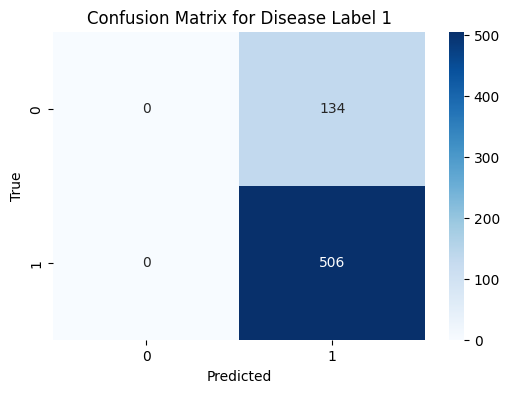

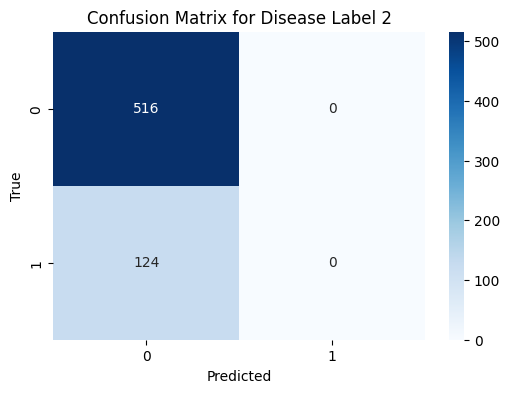

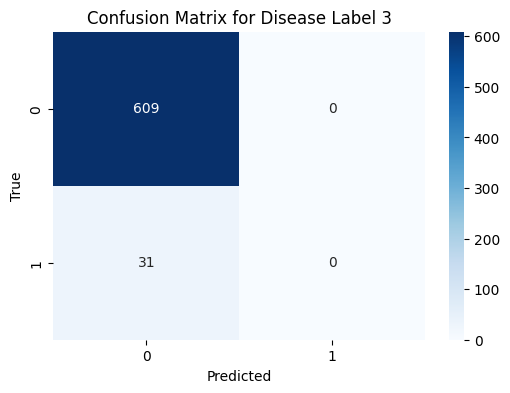

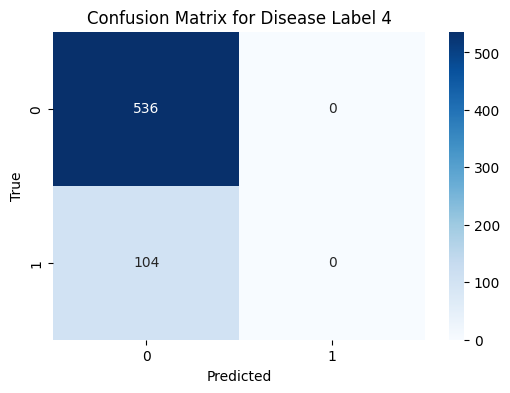

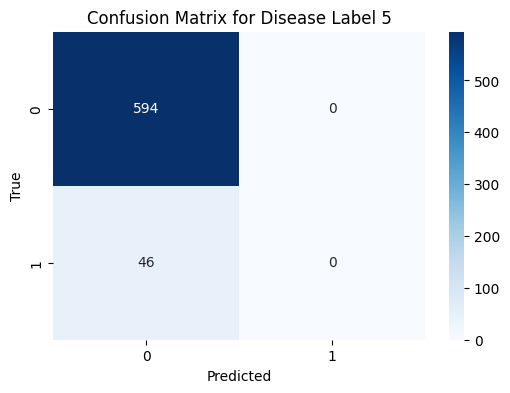

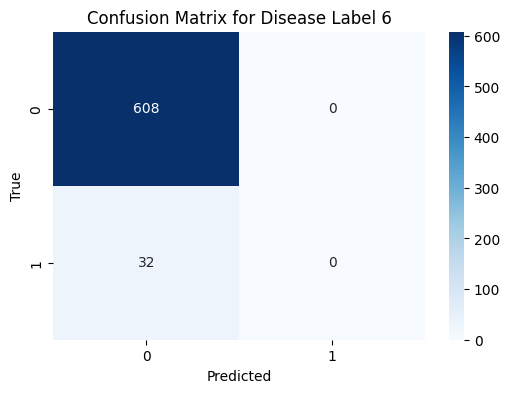

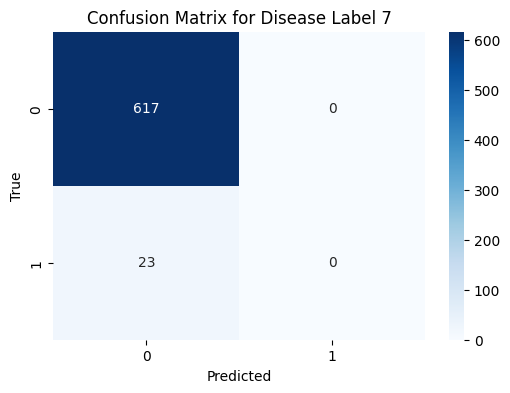

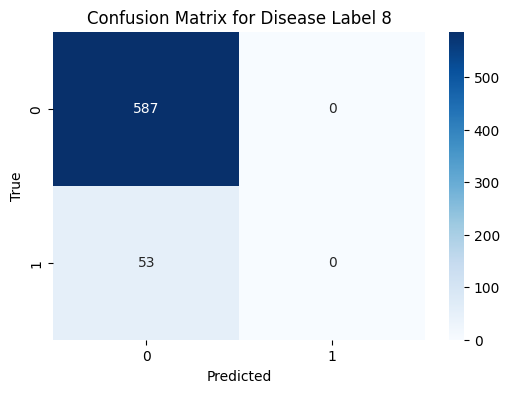

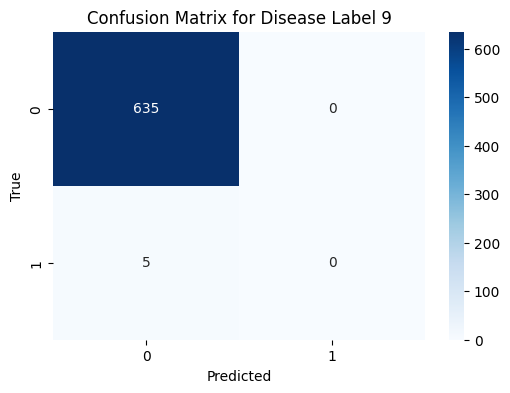

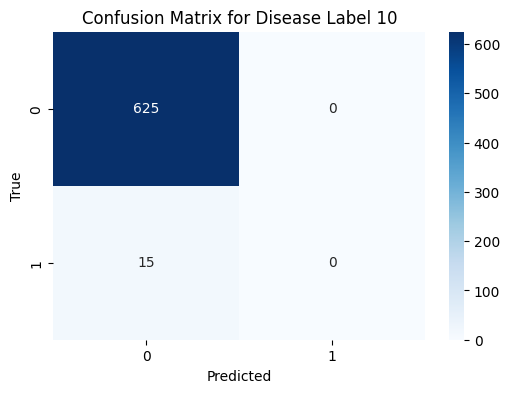

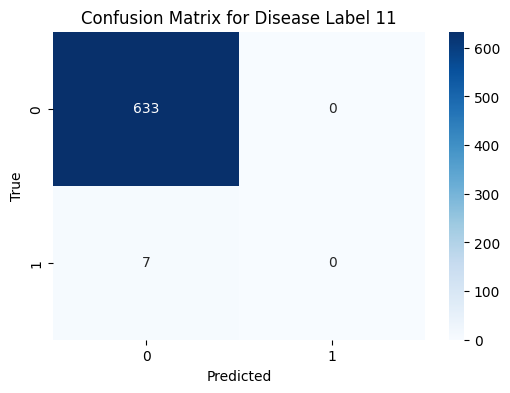

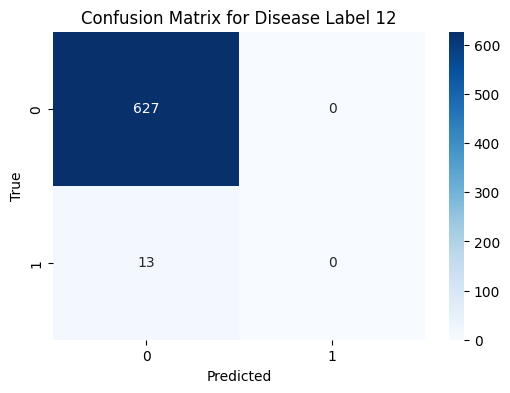

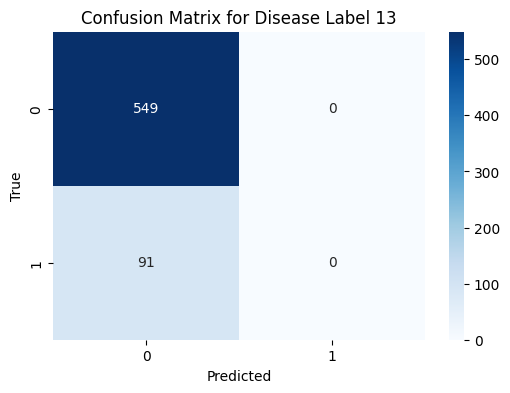

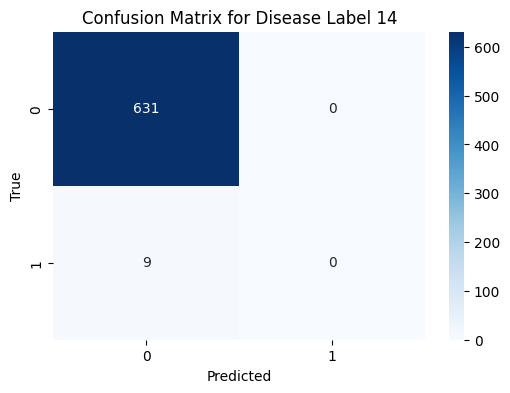

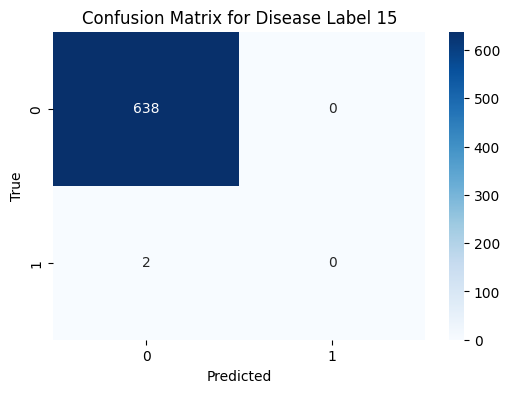

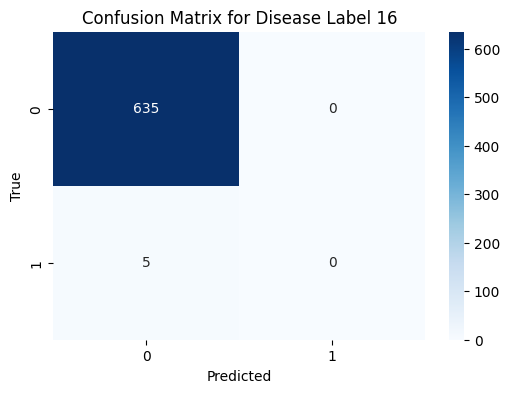

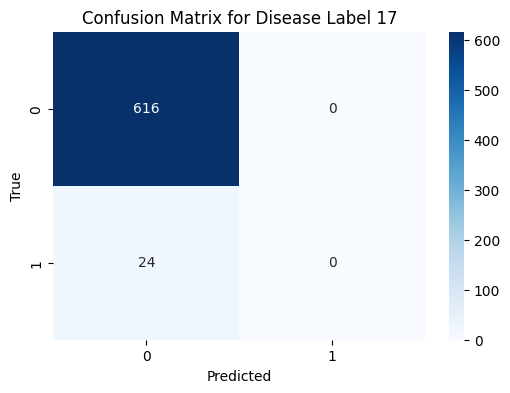

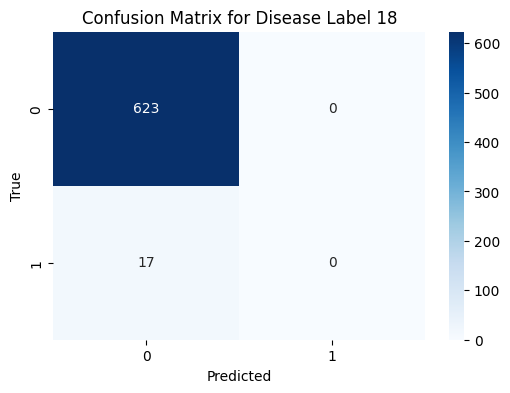

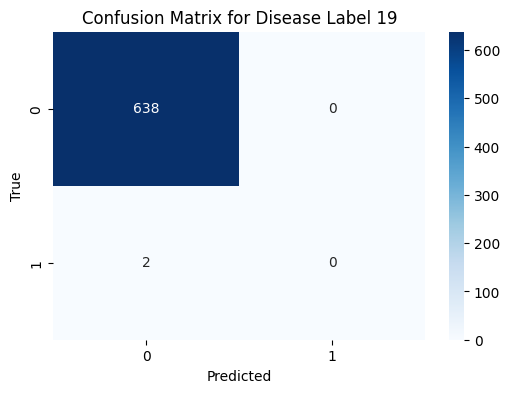

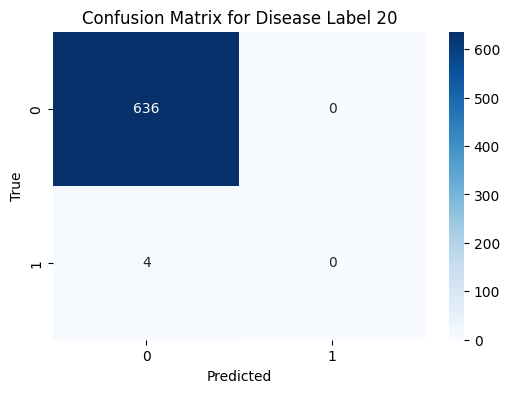

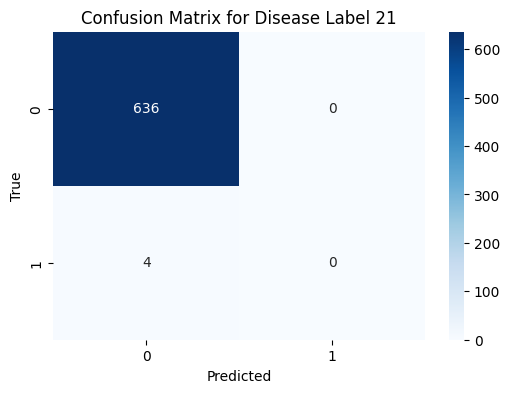

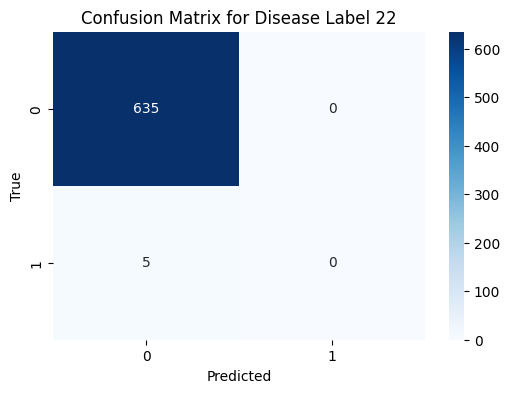

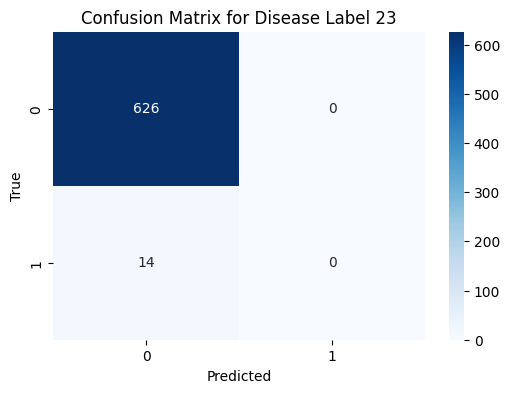

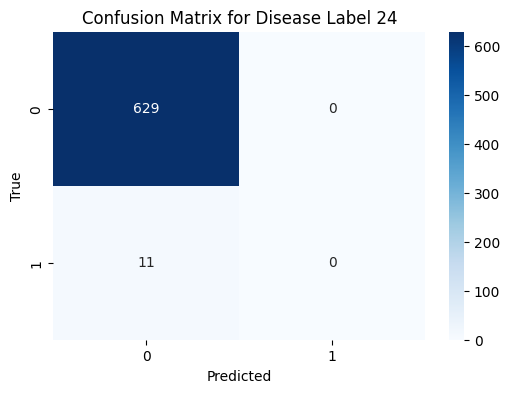

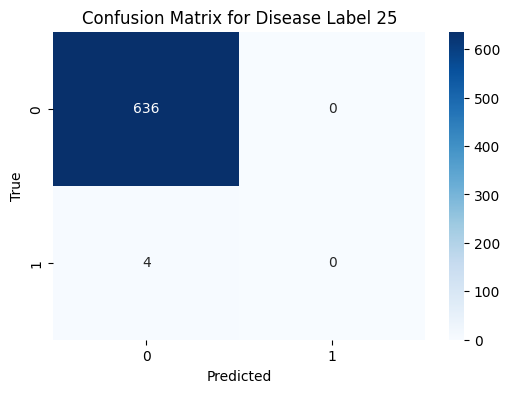

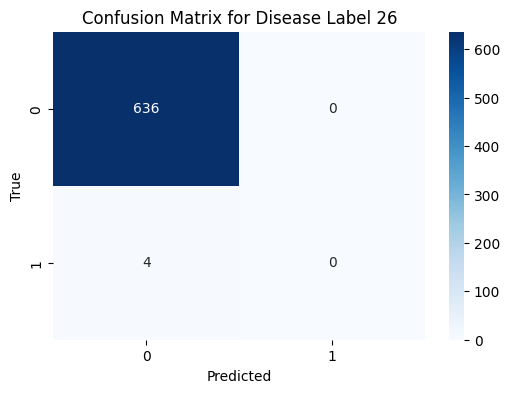

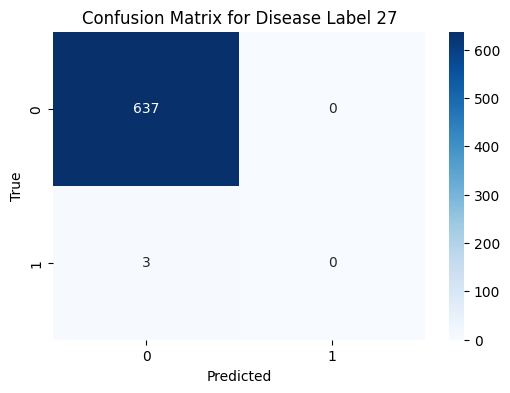

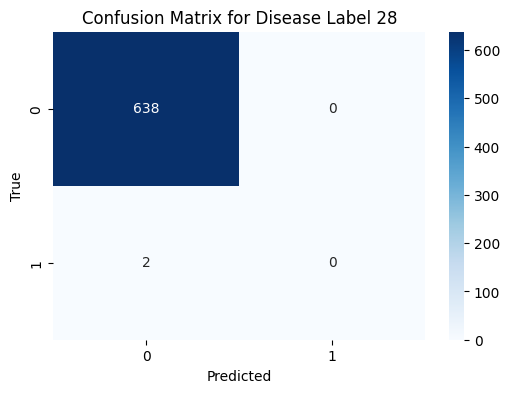

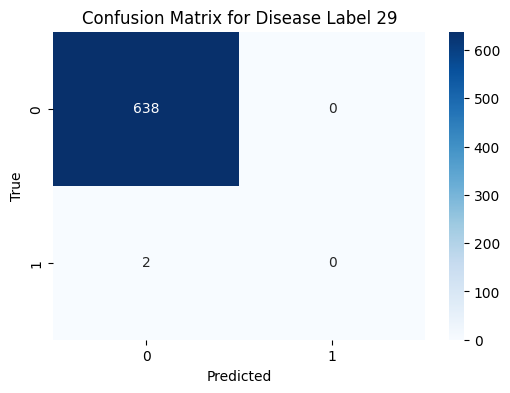

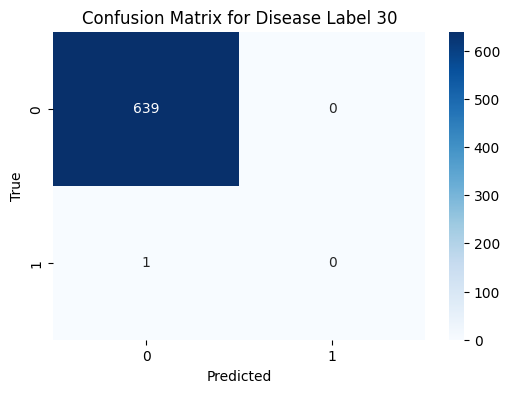

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


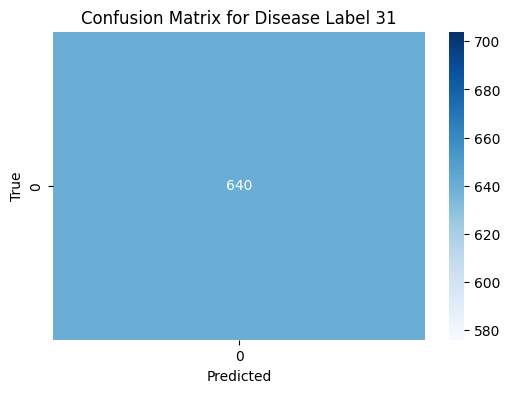

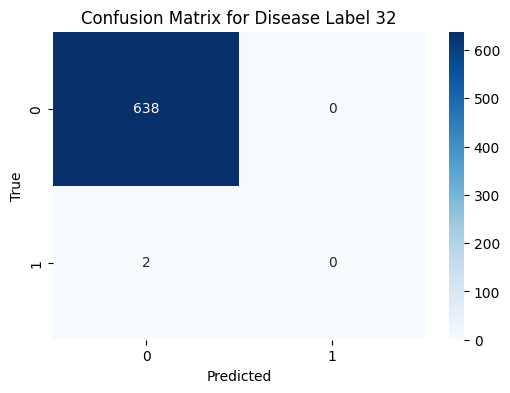

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


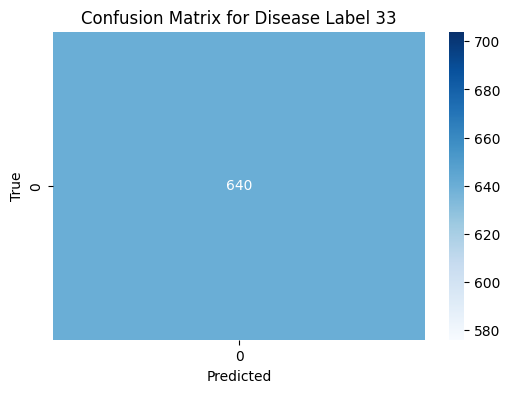

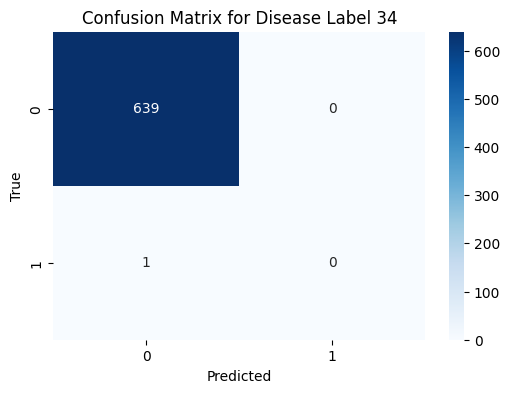

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


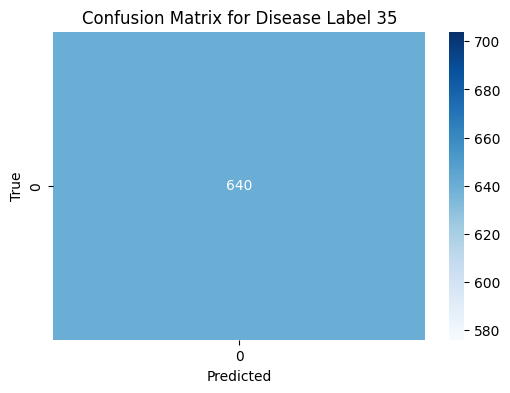

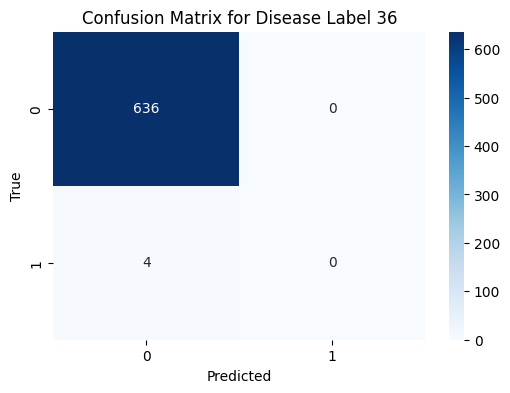

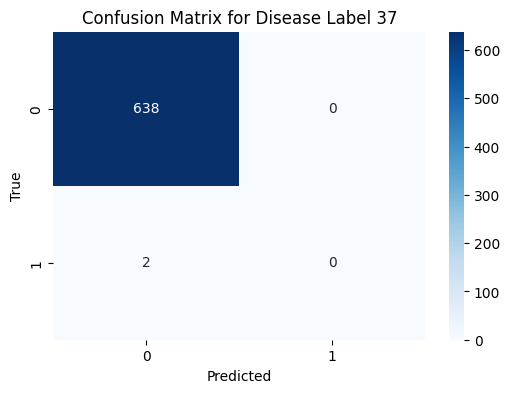

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


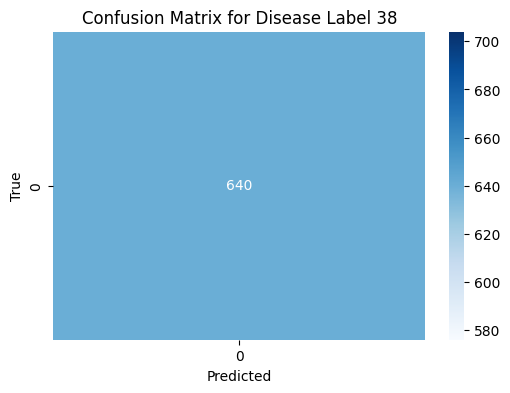

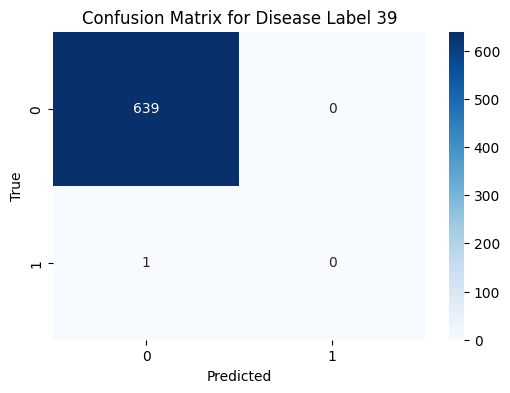

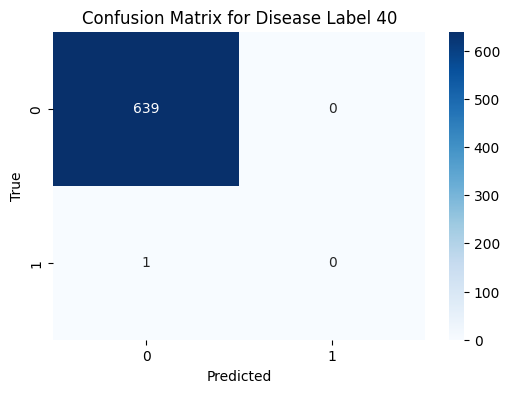

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


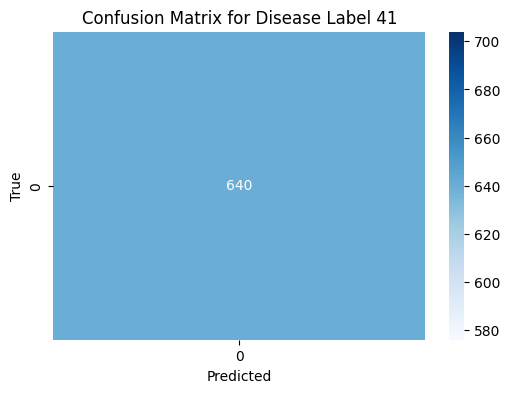

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


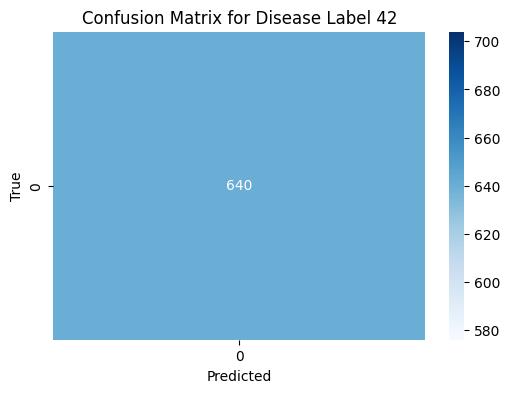

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


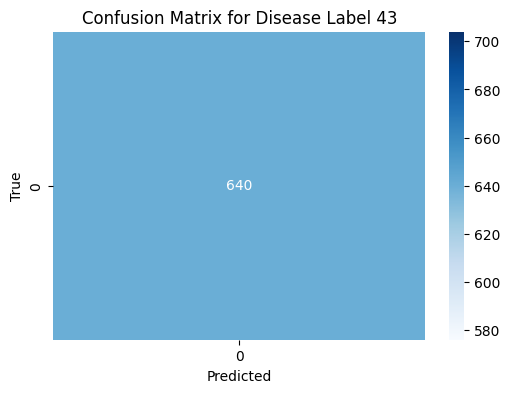

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


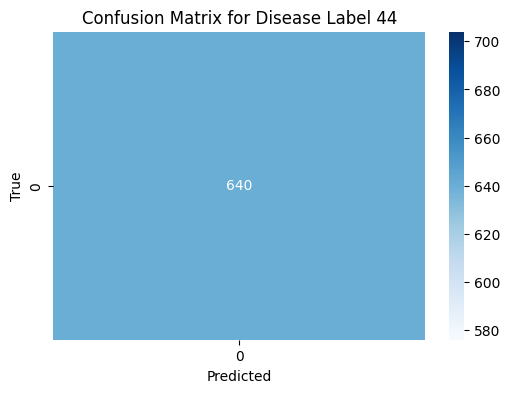

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


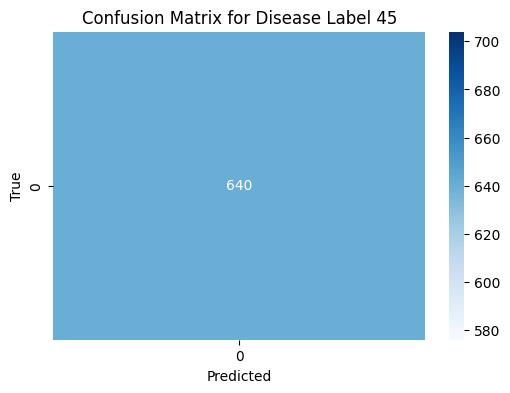

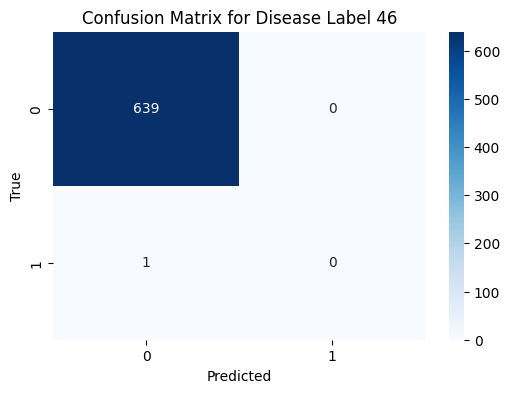

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all true labels and predictions from the generator
y_true = []
y_pred = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.append(y_batch)
    y_pred.append(model.predict(X_batch))

# Convert lists to numpy arrays
y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# Convert probabilities to binary predictions (1 if prob >= 0.5, else 0)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix for each label
for i in range(y_true.shape[1]):
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Disease Label {i+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

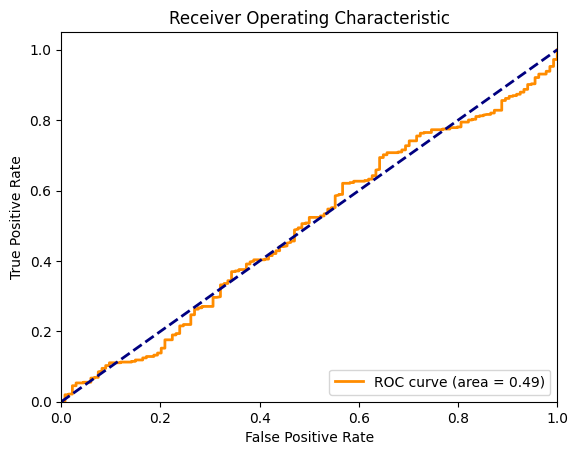

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels
y_true_bin = label_binarize(y_true, classes=range(y_pred.shape[1]))

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_true_bin[:,0], y_pred[:,0])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,559,279 (17.39 MB)

 Trainable params: 169,902 (663.68 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 339,806 (1.30 MB)

In [13]:
import tensorflow as tf
import numpy as np
import cv2
from keras.preprocessing import image
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name="block5_conv3"):
    # Get the gradient of the last convolutional layer with respect to the output
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    
    # Compute the gradient of the loss with respect to the conv outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Get the feature map and apply the weights
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())
    heatmap = np.maximum(heatmap, 0)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap /= np.max(heatmap)
    
    return heatmap

# Example usage
img_path = "retinal-disease-classification/Test_Set/Test/551.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

heatmap = grad_cam(model, img_array)
plt.imshow(heatmap, cmap='jet')
plt.show()

AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
model.save("retinal_disease_classifier.keras")